# 第2回講義 演習

今回は，深層モデルやそのライブラリは用いず，機械学習の基礎的な手法であるロジスティック回帰（およびソフトマックス回帰）を実装します．

名前に「回帰」とありますが，分類問題であることに注意してください．シグモイド関数を用いることで，データのラベルが1または0である確率を出力します．

## 目次

1. [【課題 1】ロジスティック回帰の実装と学習 (OR)](#scrollTo=quBPRwBf4Kq7&line=1&uniqifier=1)
    
    1.1. [シグモイド関数](#scrollTo=awSlFgRA4Kq9)

    1.2. [データセットの設定と重みの定義](#scrollTo=HAA-lvhz4KrF)
    
    1.3. [train関数とvalid関数](#scrollTo=7raMb3ts4KrL)
    
    1.4. [学習](#scrollTo=LiuO_6B-4Krb)

1. [【課題 2】ソフトマックス回帰の実装と学習 (MNIST)](#scrollTo=44tdPsW34Krq&line=1&uniqifier=1)
    
    2.1. [ソフトマックス関数](#scrollTo=YEprLDMd4Krr)
    
    2.2. [データセットの設定と重みの定義](#scrollTo=52fR-55x4Krx)
    
    2.3. [train関数とvalid関数](#scrollTo=80EOFI-n4Kr6)

    2.4. [学習](#scrollTo=JBGInXhG4KsJ)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

np.random.seed(34)

## 1.【課題 1】ロジスティック回帰の実装と学習 (OR)

### 1.1. シグモイド関数
$$
    \sigma({\bf x}) = \frac{1}{1 + \exp(-{\bf x})} = \frac{\exp({\bf x})}{1 + \exp({\bf x})}
$$

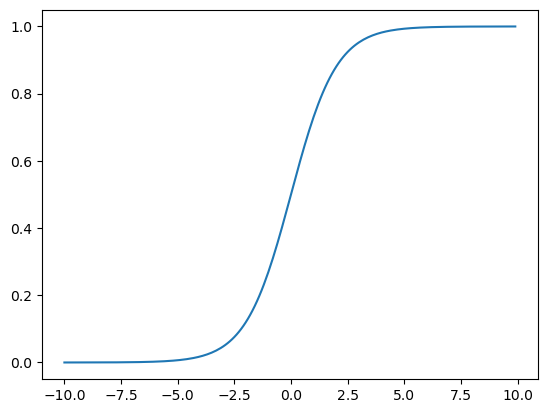

In [5]:
def sigmoid(x):
    # 単純な実装
    # return 1 / (1 + np.exp(-x))
    return  np.exp(np.minimum(x, 0)) /(1 + np.exp(-np.abs(x)))
    # expのoverflow対策を施した実装
    # x >=0 のとき sigmoid(x) = 1 / (1 + exp(-x))
    # x < 0 のとき sigmoid(x) = exp(x) / (1 + exp(x))

x = np.arange(-10, 10, 0.1)
plt.plot(x, sigmoid(x.copy()))

### 1.2. データセットの設定と重みの定義

次にデータセットと，パラメータの初期化を行います．

今回扱うORゲートは，二つの入力の少なくともどちらかが1であれば1を出力し，入力が両方とも0であれば0を出力します．

これが線形な分類器で実現可能な問題であることは，下図からもわかります．

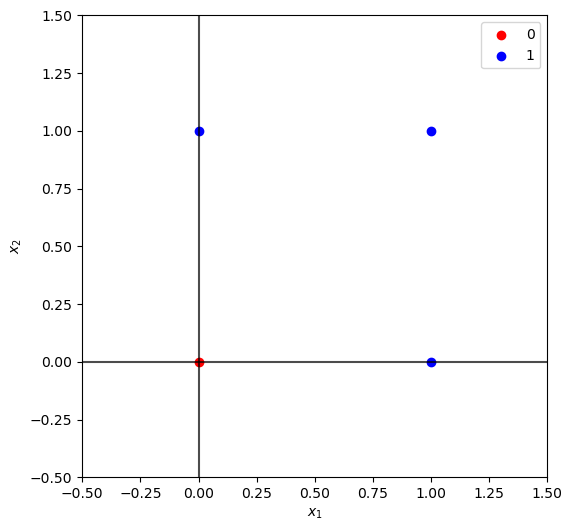

In [6]:
# ORのデータセット
x_train_or = np.array([[0, 1], [1, 0], [0, 0], [1, 1]])  # (4, 2)
y_train_or = np.array([[1], [1], [0], [1]])              # (4, 1)
x_valid_or, y_valid_or = x_train_or, y_train_or
# x_test_or, y_test_or = x_train_or, y_train_or

plt.figure(figsize=(6, 6))
plt.hlines([0], xmin=-1, xmax=2, color="black", alpha=0.7)
plt.vlines([0], ymin=-1, ymax=2, color="black", alpha=0.7)

plt.scatter(*x_train_or[y_train_or.squeeze() == 0].T, color="red", label="0")
plt.scatter(*x_train_or[y_train_or.squeeze() == 1].T, color="blue", label="1")

plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.legend()
plt.show()

次にパラメータを初期化します．重みは一様分布からのサンプリング，バイアスは0で初期化を行います．

In [7]:
# 重み（入力層の次元数: 2，出力層の次元数: 1）
W_or = np.random.uniform(low=-0.08, high=0.08, size=(2, 1)).astype('float32')
b_or = np.zeros(shape=(1,)).astype('float32')

### 1.3. train関数とvalid関数

**目的関数**

2クラス交差エントロピー誤差関数
$$ E ({\bf x}, {\bf y}; {\bf W}, {\bf b} ) =  -\frac{1}{N}\sum^N_{i=1} \left[ {\bf y}_i \log {\bf \hat{y}}_i ({\bf x}_i; {\bf W}, {\bf b}) + (1 - {\bf y}_i) \log \{ 1 - {\bf \hat{y}}_i ({\bf x}_i; {\bf W}, {\bf b}) \}\right] $$

**モデルの推論**
$$
    {\bf \hat{y}}_i = \sigma({\bf W}^T {\bf x}_i + {\bf b})
$$

**モデルの学習**

勾配降下法により学習します．クロスエントロピー誤差関数 $E$ のパラメータに関する勾配は以下のように簡単に計算できるので，それに基づいて更新を行っていきます．

\begin{align*}
    \delta_i &= {\bf \hat{y}}_i - {\bf y}_i \\
    \nabla_{\bf W} E &= \frac{1}{N}\sum^N_{i=1}\delta_i {\bf x}^{\mathrm{T}}_i \\
    \nabla_{\bf b} E &= \frac{1}{N}\sum^N_{i=1}\delta_i  \\
    {\bf W} &\leftarrow {\bf W} - \epsilon \nabla_{\bf W} E \\
    {\bf b} &\leftarrow {\bf b} - \epsilon \nabla_{\bf b} E \\
\end{align*}

In [8]:
# logの中身が0になるのを防ぐ
def np_log(x):
    return np.log(np.clip(a=x, a_min=1e-10, a_max=1e+10))

In [9]:
def train_or(x, y, eps=1.0):
    """
    :param x: np.ndarray, 入力データ, (batch_size, 入力の次元数)
    :param y: np.ndarray, 教師ラベル, (batch_size, 出力の次元数)
    :param eps: float, 学習率
    """
    global W_or, b_or

    batch_size = x.shape[0]

    # 予測
    y_hat = sigmoid(np.matmul(x, W_or) + b_or)  # (batch_size, 出力の次元数)

    # 目的関数の評価
    cost =  np.sum(y_hat * np.log(y_hat) + (1 - y)*np.log(1-y_hat))
    delta = y_hat - y  # (batch_size, 出力の次元数)

    # パラメータの更新
    dW = np.matmul(x.T, delta) / batch_size  # (入力の次元数, 出力の次元数)
    db = np.matmul(np.ones(shape=(batch_size,)), delta) / batch_size  # (出力の次元数,)
    W_or -= eps * dW
    b_or -= eps * db

    return cost

def valid_or(x, y):
    y_hat = sigmoid(np.matmul(x, W_or) + b_or)
    cost = (- y * np_log(y_hat) - (1 - y) * np_log(1 - y_hat)).mean()
    return cost, y_hat

### 1.4. 学習

In [10]:
for epoch in range(1000):
    # x_train_or, y_train_or = shuffle(x_train_or, y_train_or)
    cost = train_or(x_train_or, y_train_or)
    cost, y_pred = valid_or(x_valid_or, y_valid_or)

print(y_pred)

[[0.99181311]
 [0.99181244]
 [0.02049921]
 [0.99999857]]


## 2.【課題 2】ソフトマックス回帰の実装と学習 (MNIST)

ソフトマックス回帰は，ロジスティック回帰を多クラス分類に拡張したものです．

### 2.1. ソフトマックス関数

ソフトマックス関数は分子の全クラスにわたる和が分母になるので，モデルの出力を確率分布（多項分布）に直すものと考えることができます．

$$
\mathrm{softmax}({\bf x})_k
= \frac{\exp({\bf x}_k)}{\sum^K_{k'=1} \exp({\bf x}_{k'})}
= \frac{\exp({\bf x}_k - m)}{\sum^K_{k'=1} \exp({\bf x}_{k'} - m)} \hspace{10mm} \text{for} \, k=1,\ldots, K
$$

ソフトマックス関数は入力に対して定数を足し引きしても結果が変わりません．上式では，定数 $m = \max^K_{i=1} x_i$ を入力から引くことで，指数を取った時に値がオーバーフローしてしまうのを防ぐための実装を行っています．

In [ ]:
def softmax(x, axis=1):
    x -=  # WRITE ME# expのoverflowを防ぐ
    x_exp =  # WRITE ME
    return  # WRITE ME

x = np.random.uniform(-5, 5, (1, 10))
y = softmax(x.copy())
fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
for i, (d, title) in enumerate(zip([x, y], ['before', 'after'])):
    axs[i].bar(np.arange(10), d.squeeze())
    axs[i].set_title(f"{title} softmax")
    axs[i].set_xticks(np.arange(10))
    axs[i].set_xlabel("class")

$K=2$（2クラス）の際のソフトマックス関数を可視化してみます．

In [ ]:
x = np.stack(np.meshgrid(
    np.arange(-5, 5, 0.1),
    np.arange(-5, 5, 0.1)
))
y = softmax(x.copy(), axis=0)

ax = plt.axes(projection='3d')
ax.view_init(elev=30, azim=45)
ax.plot_surface(x[0], x[1], y[0], cmap='Reds')
ax.plot_surface(x[0], x[1], y[1], cmap='Blues')
ax.set_xlabel("x_1")
ax.set_ylabel("x_2")

### 2.2. データセットの設定と重みの定義

次にデータセットを作成します．ここでは画像の多クラス分類タスクとして知られるMNISTデータセットを用います．MNISTデータセットは0-9の手書き文字の画像入力とし，画像にどの数字が書かれているかを出力する10クラス分類のタスクです．入力データは以下のようなグレースケールの画像が入力されます．

In [ ]:
(x_mnist_1, y_mnist_1), (x_mnist_2, y_mnist_2) = mnist.load_data()

x_mnist = np.r_[x_mnist_1, x_mnist_2]
y_mnist = np.r_[y_mnist_1, y_mnist_2]

fig = plt.figure(figsize=(10, 10))

for i in range(20):
    x = x_mnist[i]
    ax = fig.add_subplot(10, 10, i+1, xticks=[], yticks=[])
    ax.imshow(x, 'gray')
fig.tight_layout(rect=[0,0,1,0.96])
plt.show()

In [ ]:
x_mnist = x_mnist.astype('float32') / 255.  # 画素値のスケーリング: 0 - 255 (整数) → 0.0 - 1.0 (浮動小数点数)
y_mnist = np.eye(N=10)[y_mnist.astype('int32').flatten()]  # 整数ラベル (0–9) を one-hot ベクトル に変換

x_mnist=x_mnist.reshape(x_mnist.shape[0],-1)  # 画素の平坦化: 28 * 28 (2次元画像) → 784 (1次元画像)

x_train_mnist, x_test_mnist, y_train_mnist, y_test_mnist = train_test_split(x_mnist, y_mnist, test_size=10000)
x_train_mnist, x_valid_mnist, y_train_mnist, y_valid_mnist = train_test_split(x_train_mnist, y_train_mnist, test_size=10000)

In [ ]:
W_mnist = np.random.uniform(low=-0.08, high=0.08, size=(784, 10)).astype('float32')  # 重み: (784, 10)
b_mnist = np.zeros(shape=(10,)).astype('float32')

### 2.3. train関数とvalid関数

**目的関数**

多クラス交差エントロピー誤差関数
$$ E ({\bf x}, {\bf y}; {\bf W}, {\bf b} ) =  -\frac{1}{N}\sum^N_{i=1} \sum^K_{k=1} {\bf y}_{i, k} \log {\bf \hat{y}}_{i, k} ({\bf x}_i; {\bf W}, {\bf b}) $$

**モデルの推論**
$$
    {\bf \hat{y}}_i = \mathrm{softmax}({\bf W}^T{\bf x}_i + {\bf b})
$$

**モデルの学習**
\begin{align*}
    \delta_i &= {\bf \hat{y}}_i - {\bf y}_i \\
    \nabla_{\bf W} E &= \frac{1}{N}\sum^N_{i=1}x_i {\bf \delta}^{\mathrm{T}}_i \\
    \nabla_{\bf b} E &= \frac{1}{N}\sum^N_{i=1}\delta_i  \\
    {\bf W} &\leftarrow {\bf W} - \epsilon \nabla_{\bf W} E \\
    {\bf b} &\leftarrow {\bf b} - \epsilon \nabla_{\bf b} E \\
\end{align*}

In [ ]:
def train_mnist(x, y, eps=1.0):
    """
    :param x: np.ndarray, 入力データ, (batch_size, 入力の次元数)
    :param y: np.ndarray, 教師ラベル, (batch_size, 出力の次元数)
    :param eps: float, 学習率
    """
    global W_mnist, b_mnist

    batch_size = x.shape[0]

    # 予測
    y_hat = softmax(np.matmul(x, W_mnist) + b_mnist)  # (batch_size, 出力の次元数)

    # 目的関数の評価
    cost = (- y * np_log(y_hat)).sum(axis=1).mean()
    delta = y_hat - y  # (batch_size, 出力の次元数)

    # パラメータの更新
    dW = np.matmul(x.T, delta) / batch_size  # (入力の次元数, 出力の次元数)
    db = np.matmul(np.ones(shape=(batch_size,)), delta) / batch_size  # (出力の次元数,)
    W_mnist -= eps * dW
    b_mnist -= eps * db

    return cost

def valid_mnist(x, y):
    y_hat = softmax(np.matmul(x, W_mnist) + b_mnist)
    cost = (- y * np_log(y_hat)).sum(axis=1).mean()

    return cost, y_hat

### 2.4. 学習

In [ ]:
for epoch in range(100):
    cost = train_mnist(x_train_mnist, y_train_mnist)

    cost, y_pred = valid_mnist(x_valid_mnist, y_valid_mnist)
    if epoch % 10 == 9 or epoch == 0:
        print('EPOCH: {}, Valid Cost: {:.3f}, Valid Accuracy: {:.3f}'.format(
            epoch + 1,
            cost,
            accuracy_score(y_valid_mnist.argmax(axis=1), y_pred.argmax(axis=1))
        ))